In [ ]:
""" The radial distribution function (RDF) can help us understand the density of various 
monomer components as a function of the distance from the pore center. 

The technique for calculating the RDF differs from how most people do it due to the 
geometry of the hexagonal phase systems.

For a standard RDF, one would measure the euclidean distance of an atom or residue
center of mass from a reference position. We can create bins in r, the distance from
the reference position, and count the number of molecules within that bin. We then normalize
by the volume of that bin (4*pi*r2^3 - 4*pi*r1^3). For more reading see: 
https://en.wikibooks.org/wiki/Molecular_Simulation/Radial_Distribution_Functions

For hexagonal phase LLC systems, it is more useful to define the bins in terms of concentric
cylinders centered at the pore centers. We bin the radial distance, calculated as the euclidean
distance between a given atom or residue center of mass with respect to the xy plane only. We 
then normalize by the volume of the cylindrical bin (height*pi*(r2^2 - r1^2))

This notebook will help you to calculate these RDFs with varying levels of complexity.

The documentation for rdf.py is located here:
https://llc-membranes.readthedocs.io/en/latest/rdf.html
"""

In [1]:
# start by importing the rdf module
from LLC_Membranes.analysis import rdf

# See the documentation for how to use the module effectively

In [2]:
# The main RDF calculations are performed using the class 'System' in rdf.py.
# The script `rdf.py` is really just a way to make it easier to interact with that object.
# In order to calculate the RDF without rdf.py, we must first initialize 'System' which is 
# done using the __init__ function within the object. However, you never actually call 
# __init__. Rather, you only need to call 'System' which automatically runs the __init__ 
# function.

# So let's start with the bare minimum

#path = '.'  # change this to the path where your trajectory to be analyzed is located
path = "/home/bcoscia/Documents/Gromacs/equilibration/dry_equilibration/Molecule_X1"

gro = 'berendsen.gro' # name of gro file that is compatible with trajectory
traj = 'PR_whole.xtc'  # gromacs trajectory file (.xtc or .trr). It's best to make molecules whole first with gmx trjconv
residue = 'R1'  # name of residue whose RDF will be measured. This is necessary because there are often multiple different residues in these systems
monomer = 'Molecule_X1' # name of monomer used to build membrane (no file extension). Need this to locate the pore centers. The appropriately annotated monomer.itp file should be located in LLC_Membranes/top/topologies

sys = rdf.System('%s/%s' %(path, gro), '%s/%s' %(path, traj), residue, monomer)

Loading Trajectory...Done!
Calculating centers of mass...Done!


In [3]:
# The above block of code load the trajectory using mdtraj and then calculated the center of
# mass of each residue

# Now we can calculate the radial distribution function
sys.radial_distribution_function(cut=2.5)  # cut defines the maximum distance from the pore center that will be binned.

100%|██████████| 166/166 [00:00<00:00, 1559.32 Frames/s]


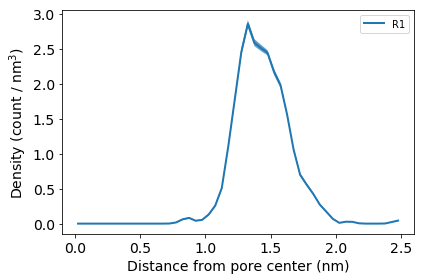

In [4]:
# The above block calculated the pore centers and then measured the distance of each center of
# mass from the pore center

# Now we can calculate uncertainties and plot the results

nboot = 200  # number of bootstrap trials
sys.bootstrap(nboot)  # generates statistics using the bootstrapping technique with nboot trials
sys.plot(show=True) # show=True tells it to show the plot

In [5]:
# This should generate a peak center around 1.4 - 1.5 nm from the pore center
# remember that we measured the distance of the monomer center of mass from the pore center
# so it makes sense that those points are situated about there.

# We can visualize the points used to calculate the rdf with the following function:

sys.build_com()

In [6]:
# A .gro file named 'com.gro' should have been created in the same directory as this notebook
# Open up com.gro in VMD.
# In the 'VMD Main' window, select the 'graphics' drop-down menu and choose 'Representations'
# In the window that popped up ('Graphical Representations'), type 'resname K' in the 
# 'Selected Atoms' box
# To make it easier to see, change the Drawing Method to CPK
# Each dot represents the center of mass of a monomer.
# NOTE: sys.build_com() by default represents all of the centers of mass as potassium (K) atoms. 
# You can change the COM representation by specifying the atom name: sys.build_com(rep=name)

In [7]:
# In the basic way we just used it, rdf.System() is not that useful.
# Instead of calculating the RDF of the monomer COM, let's isolate it to the COM of a specific
# group of atoms.

# Let's find the radial density of the pore defining atoms. These are the atoms used to locate
# the center of mass of the pore. If you don't know the names of the atoms off the top of your
# head, you can look for 'PDA' annotation in the monomer's itp file, or just use one of 
# LLC_Membranes' tools

from LLC_Membranes.llclib.topology import LC

pore_defining_atoms = LC(monomer).pore_defining_atoms  # LC() reads the annotations in monomer.itp
print(pore_defining_atoms)

['C1', 'C2', 'C3', 'C4', 'C5', 'C6']


Loading Trajectory...Done!
Calculating centers of mass...

100%|██████████| 166/166 [00:00<00:00, 2221.14 Frames/s]

Done!


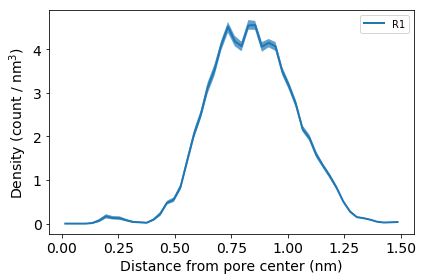

In [8]:
# Now repeat the above, but restricted to the pore defining atoms
sys = rdf.System('%s/%s' %(path, gro), '%s/%s' %(path, traj), residue, monomer, atoms=pore_defining_atoms)
sys.radial_distribution_function(cut=1.5)  # made the max radial distance smaller
sys.bootstrap(nboot)
sys.plot(show=True)

Calculating pore spline...
Attempting to load spline ... 

  1%|          | 2/166 [00:00<00:08, 19.79it/s]

spline.pl not found ... Calculating spline


100%|██████████| 166/166 [00:00<00:00, 855.37 Frames/s]

Calculating component density


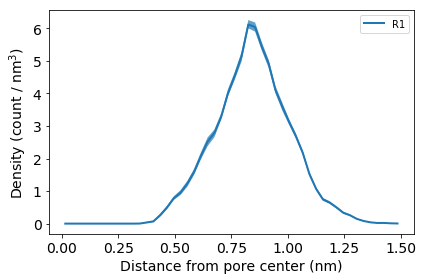

In [9]:
# Now we have a density of just the center of mass of the pore defining atoms.
# It might look a little jagged. 
# That is because the pores are not perfect cylinders. The edges aren't perfectly defined
# and there is somewhat of a z-dependence to the pore's radius and center.
# To deal with this, you can construct a spline through the center of the pore. To do so,
# the pore is broken into bins in the z direction. The center of mass of any pore defining
# atoms which occupy that bin are used to locate the pore center within the bin. 
# If there are ten bins, then there are 10 points making a spline that runs through the pore
# center.
# The distance to the pore center is calculated based on the radial distance from the point
# to the spline. The pore center is interpolated for in-between values.
# To implement the spline, just add spline = True to the radial distribution and recalculate

sys.radial_distribution_function(cut=1.5, spline=True)  # made the max radial distance smaller
sys.bootstrap(nboot)
sys.plot(show=True)

In [10]:
# Hopefully that smoothed things. If it didn't, it's still the best way to calculate the RDF.
# You can visualize the spline if you add build=True when you call radial_distribution_function

sys.radial_distribution_function(cut=1.5, spline=True, build=True)  # made the max radial distance smaller

Calculating pore spline...
Attempting to load spline ... Success!


 42%|████▏     | 70/166 [00:00<00:00, 696.45 Frames/s]

Calculating component density


100%|██████████| 166/166 [00:00<00:00, 683.40 Frames/s]


In [11]:
# open spline.gro in VMD
# open up the Graphical Representations panel (Graphics -> representations) from VMD Main window)
# type resname K into the 'Selected Atoms' box and change the Drawing method to CPK. 
# You should now see the points which make up the spline
# Click the 'Create Rep' button at the top of graphical representations
# In 'Selected atoms' type 'name' and then the names of pore defining atoms. So for Molecule_X1
# you would type 'name C1 C2 C3 C4 C5 C6'
# You should now be able to see the spline running through the pore. Its easier to see if you 
# change the pore defining atoms drawing method to Lines

In [12]:
# Now let's try some stuff on your own.
# (1) Plot the RDF of the pore definining atoms AND some other component
# For Molecule_X1, use the monomer's nitrogen atom as the other component

In [15]:
# (2) Plot the RDF of the pore defining atoms again, but do not calculate the center of mass
# of the group. Plot it on top of that calculated using the centers of mass.
# Hint: read documentation for rdf.System()

In [14]:
# (3) Calculate the RDF of (i) the tails (without the center of mass), (ii) the center of mass of 
# the pore defining atoms and (iii) the nitrogen atom of Molecule_X1

In [16]:
# (4) Do the same as (1), (2) and (3) but use rdf.py on the command line. (You can make a 
# shell script so that you save your work)
# The documentation will be helpful here.